# Analysis of first image of CTIO data 2017
===============================================================


- Author : Sylvie Dagoret-Campagne
- date : January 11th 2017

This notebook shows how to extract a spectrum from the image.


### Defines packages
======================

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [65]:
from scipy import stats  
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [66]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


##### photutils
------------
https://photutils.readthedocs.io/en/latest/

In [67]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [68]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),  # default figure size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [69]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2017-01-11 21:10:38.570081
fits date format for the analysis :  2017-01-11T21:10:38


### defines the input file
=========================

In [70]:
path_img='.'
file_img='trim_fileno016.fits'
object_name=file_img.split('.')[0]

In [71]:
fullfile=os.path.join(path_img,file_img)

### Open input file
===================

In [72]:
prim_hdr=fits.getheader(fullfile) # 

In [73]:
exposure = prim_hdr['EXPTIME']
date_obs = prim_hdr['DATE-OBS']

In [74]:
print 'date obs = ',date_obs
print 'exposure = ',exposure,'seconds'

date obs =  2016-08-23T02:55:43.922
exposure =  20.0 seconds


In [75]:
hdu_list=fits.open(fullfile)
hdu_list.info()

Filename: ./trim_fileno016.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     133   (2048, 2048)   float64   


In [76]:
header=hdu_list[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBJECT  = 'HD205905'           / Name of object observed                        
OBSERVER= 'Mondrik '           / observer                                       
PROPID  = 'Stubbs  '           / Proposal ID                                    
RECID   = 'ct36.20160823.025543' / NOAO Archibe record ID                       
PROPID  = 'Stubbs  '           / Proposal ID                                    
IMAGETYP= 'object  '        

### extract the image
=======================

In [77]:
image_data = hdu_list[0].data

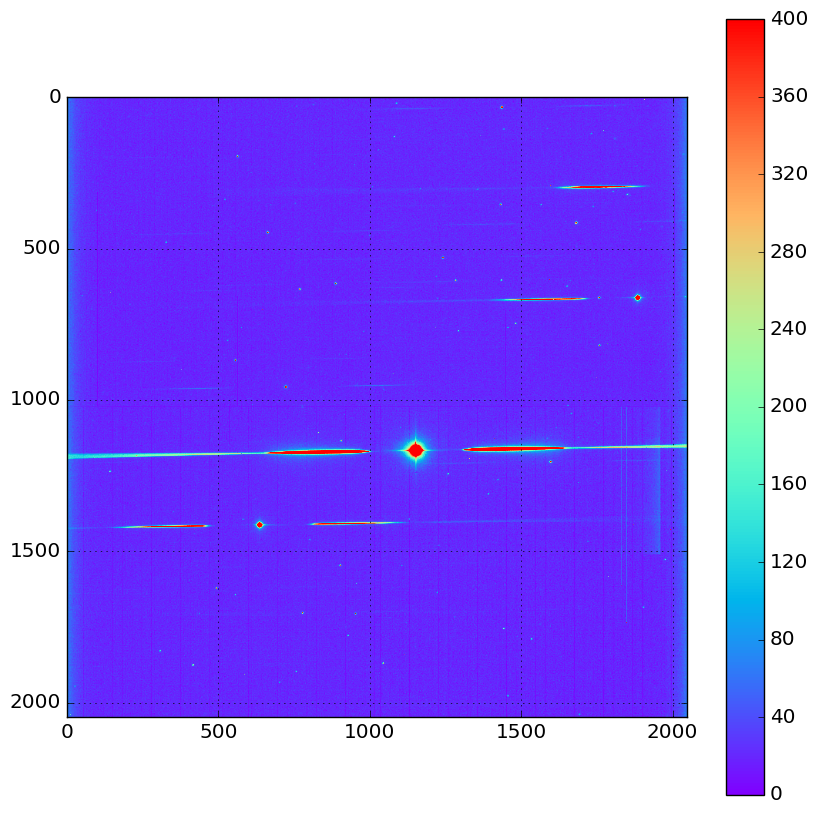

In [78]:
im=plt.imshow(image_data,cmap='rainbow',vmin=0,vmax=400)
plt.colorbar(im)
plt.grid(True)

In [79]:
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, iters=5)
print((mean, median, std))    

(21.789718310034839, 22.0, 6.8522320329601731)


### Min and Max of the image
==============================

In [80]:
print(type(image_data))
print('image shape',image_data.shape)
themin=image_data.min()
themax=image_data.max()
print('min and max',themin,themax)

<type 'numpy.ndarray'>
('image shape', (2048, 2048))
('min and max', -207.0, 61772.0)


### Histogram of image values
================================

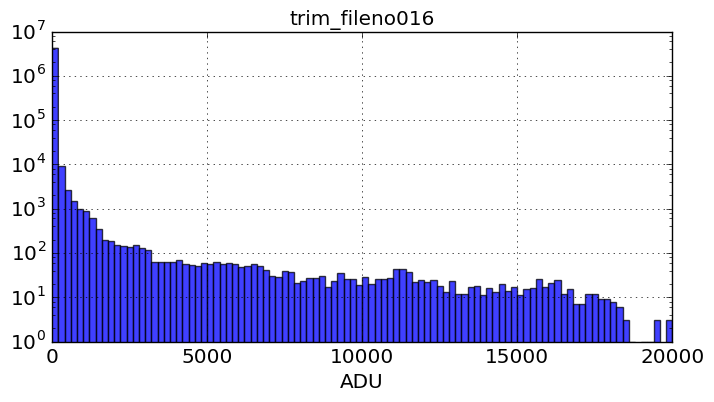

In [81]:
title=object_name
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(111)
image_data_flat=image_data.flatten()
plt.hist(image_data_flat,bins=100,range=[0,20000],facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
ax.grid(True)
plt.yscale('log')
plt.show()

### Transfer the image in CCDData
====================================

In [82]:
ccd=ccdproc.CCDData.read(fullfile, hdu=0,unit="adu") 

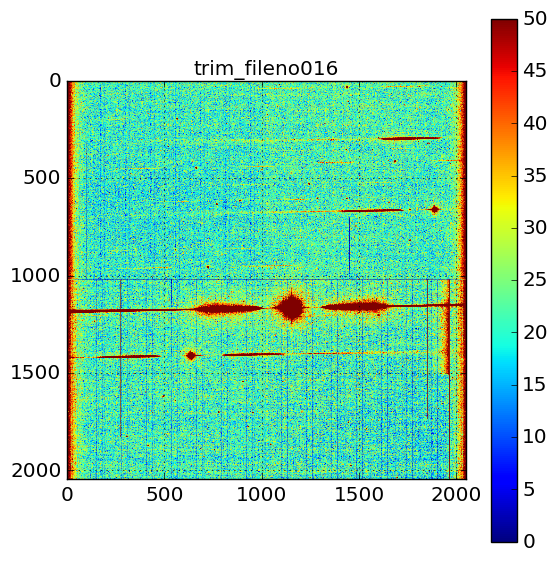

In [83]:
ig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(ccd,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
plt.savefig(object_name)

### Rotation of the image
==========================

In [84]:
rotation_angle=-1  # rotation in degree

In [85]:
rotated_image=ndimage.interpolation.rotate(ccd,rotation_angle)

#### rotated image
-----------------

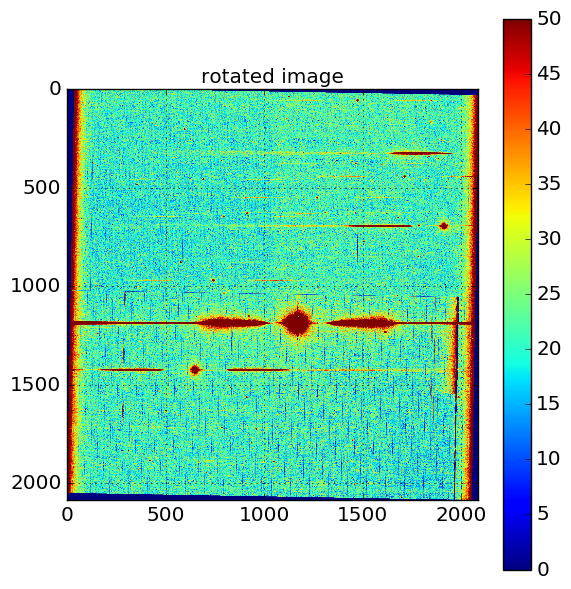

In [86]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(rotated_image,vmin=0,vmax=50.)
plt.title('rotated image')
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
plt.tight_layout()
plt.savefig('imagerot')

### We search the position of the central star

In [87]:
themaximum=rotated_image.max()

In [88]:
imax,jmax = np.unravel_index(rotated_image.argmax(),rotated_image.shape)
print imax,' ',jmax

1207   1165


In [89]:
rotated_image.shape

(2083, 2083)

In [90]:
max_index_y=rotated_image.shape[0]-1
max_index_x=rotated_image.shape[1]-1

### Check center and the rotation
=================================

In [91]:
imax=1190  # put by hand
w=10

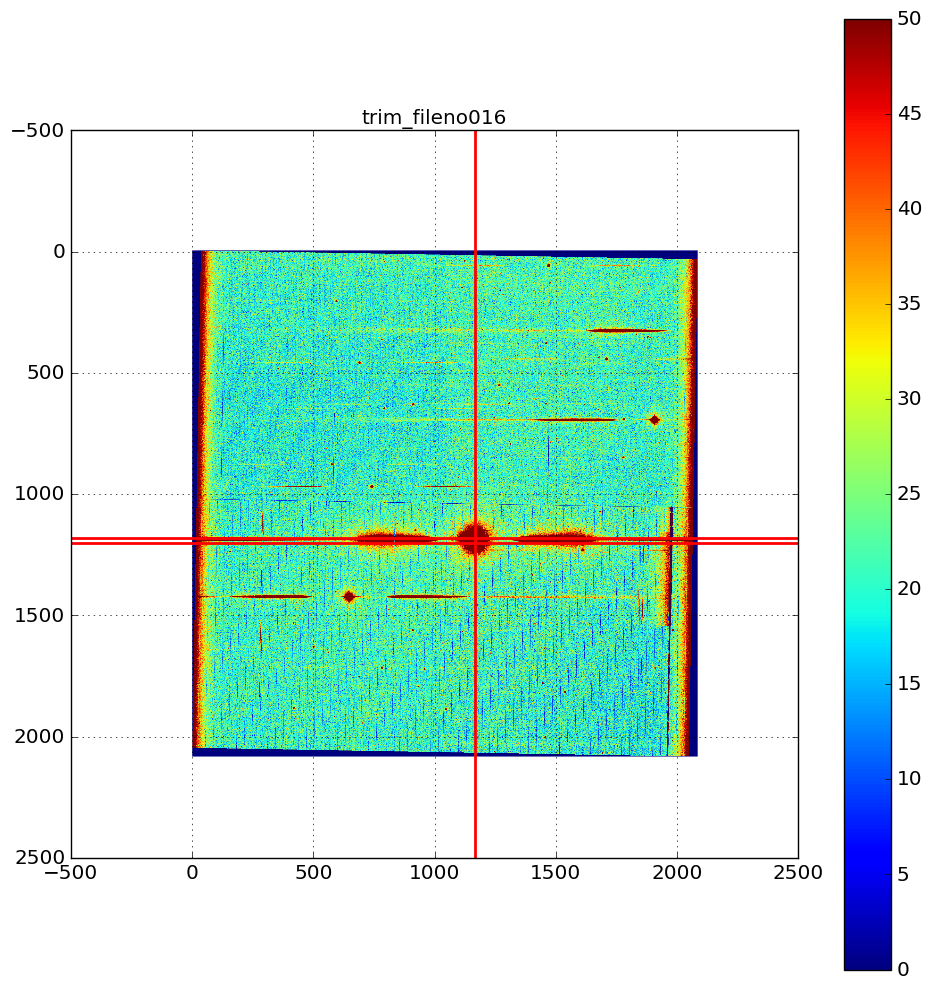

In [92]:
# check the central region is OK
# -------------------------------
fig, ax = plt.subplots(figsize=(10,10))
img=ax.imshow(rotated_image,vmin=0,vmax=50.)
plt.colorbar(img)
ax.plot([-500, 2500], [imax-w, imax-w], color='r', linestyle='-', linewidth=2)
ax.plot([-500, 2500], [imax+w, imax+w], color='r', linestyle='-', linewidth=2)
ax.plot([jmax,jmax], [-500,2500], color='r', linestyle='-', linewidth=2)
plt.title(object_name)
plt.tight_layout()
plt.grid(True)

### Extract  Profiles of three vertical slices
-------------------------------

In [93]:
profile1=np.sum(rotated_image[:,700:1000],axis=1)  # left wing profile
profile2=np.sum(rotated_image[:,1200:1300],axis=1) # central star profile
profile3=np.sum(rotated_image[:,1300:1800],axis=1) # right wing profile 

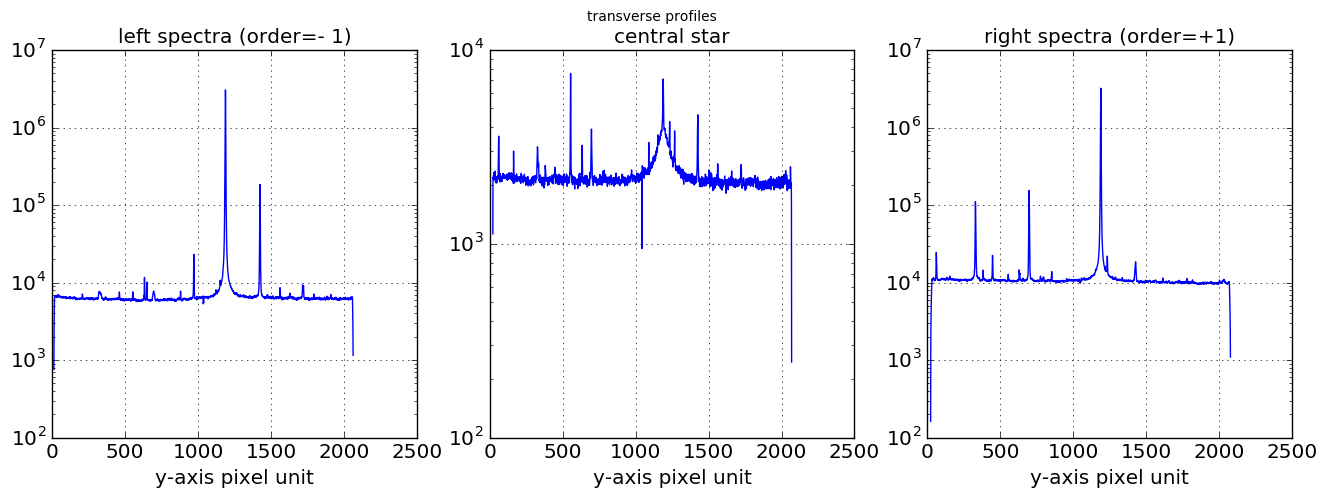

In [94]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1)
ax2.semilogy(profile2)
ax3.semilogy(profile3)
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_title('left spectra (order=- 1)')
ax2.set_title('central star')
ax3.set_title('right spectra (order=+1)')
ax1.set_xlabel('y-axis pixel unit')
ax2.set_xlabel('y-axis pixel unit')
ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

### Zoom on the profiles

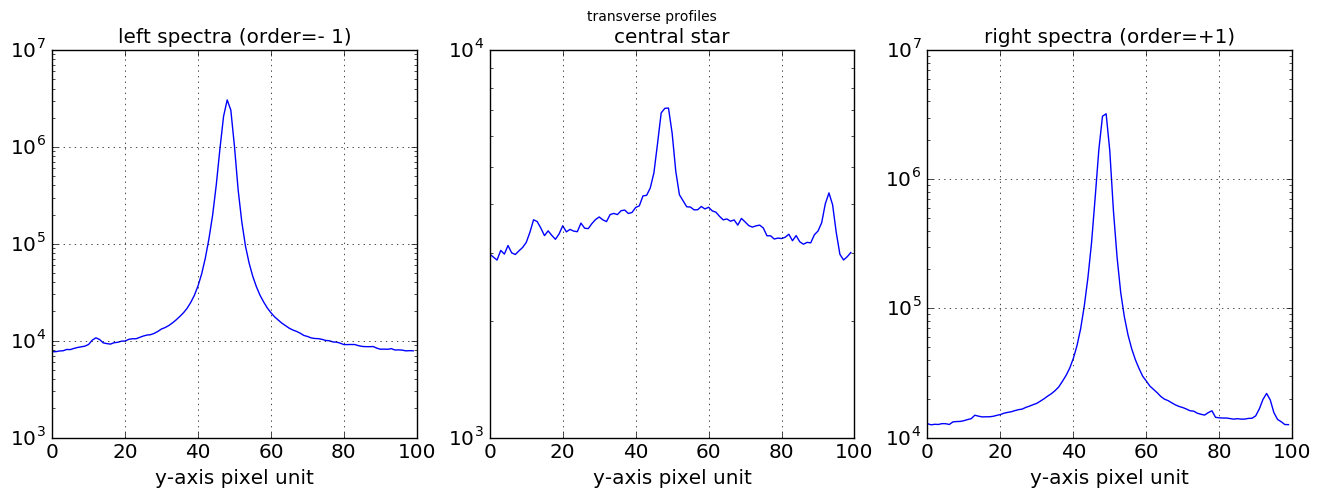

In [95]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1[imax-5*w:imax+5*w])
ax2.semilogy(profile2[imax-5*w:imax+5*w])
ax3.semilogy(profile3[imax-5*w:imax+5*w])
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_title('left spectra (order=- 1)')
ax2.set_title('central star')
ax3.set_title('right spectra (order=+1)')
ax1.set_xlabel('y-axis pixel unit')
ax2.set_xlabel('y-axis pixel unit')
ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

#### Extraction of spectrum region
------------------------------


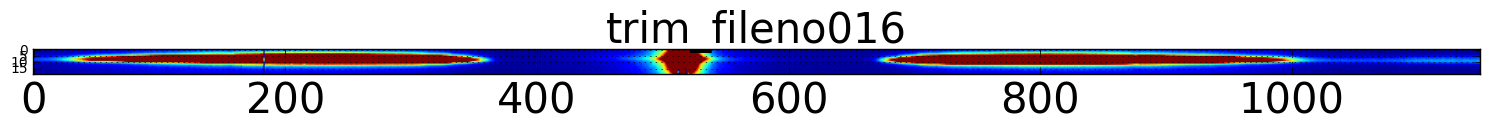

In [96]:
fig, ax = plt.subplots(figsize=(15, 10))
spectraregion=np.copy(rotated_image[imax-w:imax+w,650:1800])
spectraregionav=spectraregion/(2*w)
ax.imshow(spectraregionav,vmin=0,vmax=50.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)
plt.tight_layout()

### Spectrum
==============

In [97]:
spectrum=np.sum(spectraregionav,axis=0)

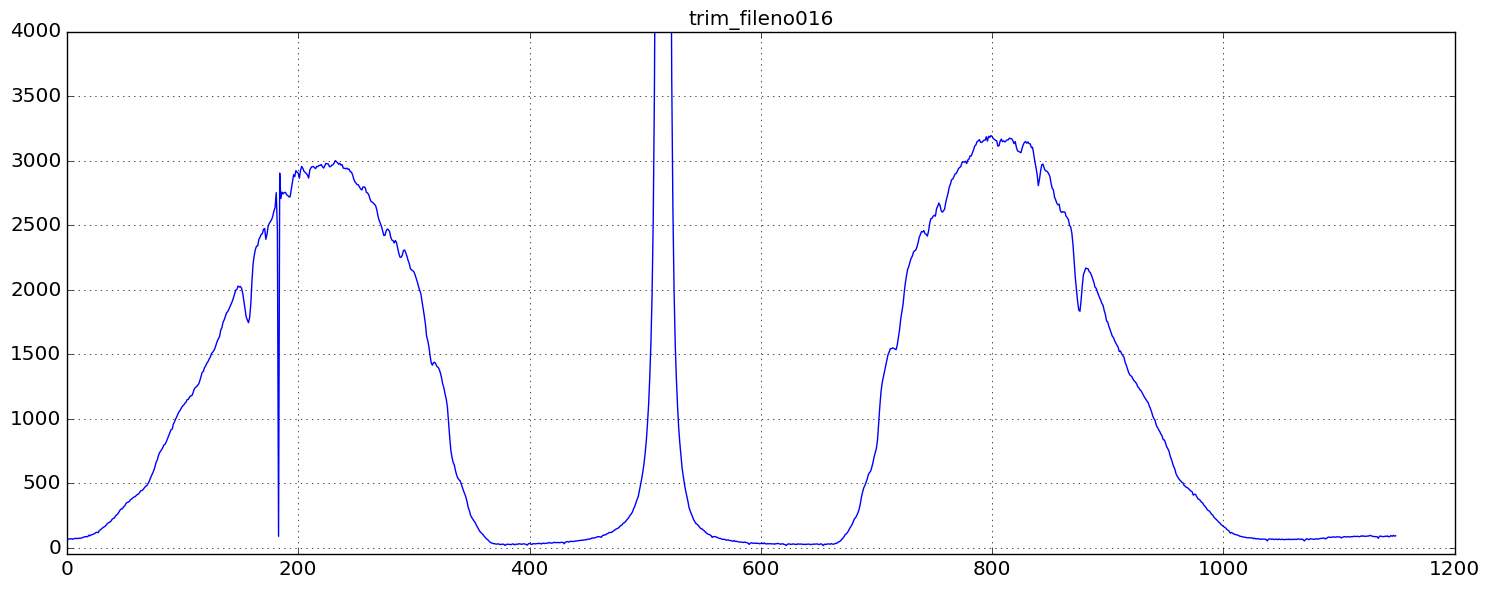

In [98]:
fig, ax = plt.subplots(figsize=(15, 6))
#plt.semilogy(spectrum)
plt.plot(spectrum)
plt.ylim(-50.,4000.)
plt.title(object_name)
plt.tight_layout()
#plt.xlim(0.,1000.)
plt.grid(True)
#plt.savefig(outputfigfilename6)
